<a href="https://colab.research.google.com/github/ekomey/SVR-Regression/blob/Essam's-Branch/Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import LabelEncoder,StandardScaler,MinMaxScaler,RobustScaler

In [28]:
from google.colab import files
uploaded = files.upload()

data = pd.read_csv("Metro_Interstate_Traffic_Volume.csv")
data.head()

Saving Metro_Interstate_Traffic_Volume.csv to Metro_Interstate_Traffic_Volume (2).csv


,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,date_time,traffic_volume
0,None,288.28,0.0,0.0,40,Clouds,scattered clouds,10/2/2012 9:00,5545
1,None,289.36,0.0,0.0,75,Clouds,broken clouds,10/2/2012 10:00,4516
2,None,289.58,0.0,0.0,90,Clouds,overcast clouds,10/2/2012 11:00,4767
3,None,290.13,0.0,0.0,90,Clouds,overcast clouds,10/2/2012 12:00,5026
4,None,291.14,0.0,0.0,75,Clouds,broken clouds,10/2/2012 13:00,4918


In [14]:
le =LabelEncoder()

Holiday_labels = le.fit_transform(data['holiday'])

{index: label for index , label in enumerate(le.classes_)}

{0: 'Christmas Day',
 1: 'Columbus Day',
 2: 'Independence Day',
 3: 'Labor Day',
 4: 'Martin Luther King Jr Day',
 5: 'Memorial Day',
 6: 'New Years Day',
 7: 'None',
 8: 'State Fair',
 9: 'Thanksgiving Day',
 10: 'Veterans Day',
 11: 'Washingtons Birthday'}

In [15]:
weather_main = le.fit_transform(data['weather_main'])
{index: label for index , label in enumerate(le.classes_)}

{0: 'Clear',
 1: 'Clouds',
 2: 'Drizzle',
 3: 'Fog',
 4: 'Haze',
 5: 'Mist',
 6: 'Rain',
 7: 'Smoke',
 8: 'Snow',
 9: 'Squall',
 10: 'Thunderstorm'}

In [16]:
weather_description = le.fit_transform(data['weather_description'])
{index: label for index , label in enumerate(le.classes_)}

{0: 'SQUALLS',
 1: 'Sky is Clear',
 2: 'broken clouds',
 3: 'drizzle',
 4: 'few clouds',
 5: 'fog',
 6: 'freezing rain',
 7: 'haze',
 8: 'heavy intensity drizzle',
 9: 'heavy intensity rain',
 10: 'heavy snow',
 11: 'light intensity drizzle',
 12: 'light intensity shower rain',
 13: 'light rain',
 14: 'light rain and snow',
 15: 'light shower snow',
 16: 'light snow',
 17: 'mist',
 18: 'moderate rain',
 19: 'overcast clouds',
 20: 'proximity shower rain',
 21: 'proximity thunderstorm',
 22: 'proximity thunderstorm with drizzle',
 23: 'proximity thunderstorm with rain',
 24: 'scattered clouds',
 25: 'shower drizzle',
 26: 'shower snow',
 27: 'sky is clear',
 28: 'sleet',
 29: 'smoke',
 30: 'snow',
 31: 'thunderstorm',
 32: 'thunderstorm with drizzle',
 33: 'thunderstorm with heavy rain',
 34: 'thunderstorm with light drizzle',
 35: 'thunderstorm with light rain',
 36: 'thunderstorm with rain',
 37: 'very heavy rain'}

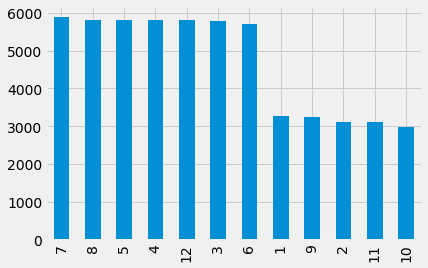

In [44]:
data['holiday'] = le.fit_transform(data['holiday'])
data['weather_main'] = le.fit_transform(data['weather_main'])
data['weather_description'] = le.fit_transform(data['weather_description'])


# aggregate rows with same date-time
data_agg = data.groupby('date_time',as_index=False).agg('max')

data_agg['date_time'] = pd.to_datetime(data_agg['date_time'])
# convert date_time column to datetime format

# create column with hours from date_time
data_agg['hour'] = data_agg['date_time'].dt.hour
data_agg['hour'].value_counts().plot(kind='bar')

# create column with day of the week from date_time
data_agg['day_of_week'] = data_agg['date_time'].dt.dayofweek
data_agg['day_of_week'].value_counts().plot(kind='bar')

# create column with month from date_time
data_agg['month'] = data_agg['date_time'].dt.month
data_agg['month'].value_counts().plot(kind='bar')

In [53]:
data_agg.head()
data_agg.drop(['date_time'], axis=1)

,holiday,temp,rain_1h,snow_1h,clouds_all,weather_main,weather_description,traffic_volume,hour,day_of_week,month
0,6,263.49,0.0,0.0,58,1,2,1439,0,1,1
1,7,260.19,0.0,0.0,1,0,27,1747,10,1,1
2,7,260.49,0.0,0.0,20,1,4,2291,11,1,1
3,7,261.10,0.0,0.0,20,1,4,2588,12,1,1
4,7,261.55,0.0,0.0,20,1,4,2927,13,1,1
...,...,...,...,...,...,...,...,...,...,...,...
40570,7,284.87,0.0,0.0,1,0,27,541,5,6,9
40571,7,284.65,0.0,0.0,1,5,17,1140,6,6,9
40572,7,284.11,0.0,0.0,1,5,17,1806,7,6,9
40573,7,284.66,0.0,0.0,20,5,17,2224,8,6,9


In [57]:
# save preprocessed data to csv
data_agg.to_csv("Metro-Interstate-Traffic-Volume-Encoded.csv", index=False)

(40575, 12)
(40575, 12)
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
MinMaxScaler(copy=True, feature_range=(0, 1))
Epoch: 0
Epoch: 100
Epoch: 200
Epoch: 300
Epoch: 400
Epoch: 500
Epoch: 600
Epoch: 700
Epoch: 800
Epoch: 900
Accuracy: [16573804.     8416345.      463633.5   ...  5674370.5    1392179.
   106337.055]
Prediction: [[1478.9064]
 [1478.9064]
 [1478.9064]
 ...
 [1478.9064]
 [1478.9064]
 [1478.9064]]


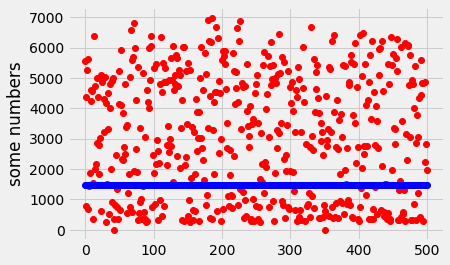

In [58]:
import math
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import seed
seed(1)
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import tensorflow
tensorflow.random.set_seed(1)
from tensorflow.python.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.wrappers.scikit_learn import KerasRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns

dataset = df2.copy()
dataset.tail()

df = df2.dropna()
print(df.shape)

import io
df2 = pd.read_csv('Metro-Interstate-Traffic-Volume-Encoded.csv')
df = df2.dropna()
print(df.shape)
df.head()
# Dataset is now stored in a Pandas Dataframe

xvars = ["temp", "rain_1h", "snow_1h", "clouds_all","holiday","weather_main","weather_description", "hour", "day_of_week", "month"]  # taking the variables that we want to keep as our predictor variables, and putting them into a NumPy Array

X = df.loc[:, xvars].values   # get X values (i.e. predictors/features) # casting our predictors into a NumPy array
y = df.loc[:, "traffic_volume"].values  # get y values (i.e., outcome/target variable)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

y_train=np.reshape(y_train, (-1,1))
y_val=np.reshape(y_val, (-1,1))
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()
print(scaler_x.fit(X_train))
xtrain_scale=scaler_x.transform(X_train)
print(scaler_x.fit(X_val))
xval_scale=scaler_x.transform(X_val)
print(scaler_y.fit(y_train))
ytrain_scale=scaler_y.transform(y_train)
print(scaler_y.fit(y_val))
yval_scale=scaler_y.transform(y_val)


#Network parameters
n_hidden1 = 10
n_hidden2 = 10
n_input = 10
n_output = 1
#Learning parameters
learning_constant = 0.2
number_epochs = 1000
batch_size = 1000

#Defining the input and the output
tf.disable_v2_behavior()
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_output])
#DEFINING WEIGHTS AND BIASES
#Biases first hidden layer
b1 = tf.Variable(tf.random_normal([n_hidden1]))
#Biases second hidden layer
b2 = tf.Variable(tf.random_normal([n_hidden2]))
#Biases third hidden layer
b3 = tf.Variable(tf.random_normal([n_hidden3]))
#Biases output layer
b4 = tf.Variable(tf.random_normal([n_output]))
#Weights connecting input layer with first hidden layer
w1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))
#Weights connecting first hidden layer with second hidden layer
w2 = tf.Variable(tf.random_normal([n_hidden1, n_hidden2]))
#Weights connecting second hidden layer with third hidden layer
w3 = tf.Variable(tf.random_normal([n_hidden2, n_hidden3]))
#Weights connecting third hidden layer with output layer
w4 = tf.Variable(tf.random_normal([n_hidden3, n_output]))

def multilayer_perceptron(input_d):
 #Task of neurons of first hidden layer
 layer_1 = tf.nn.sigmoid(tf.add(tf.matmul(input_d, w1), b1))
 #Task of neurons of second hidden layer
 layer_2 = tf.nn.sigmoid(tf.add(tf.matmul(layer_1, w2), b2))
  #Task of neurons of third hidden layer
 layer_3 = tf.nn.sigmoid(tf.add(tf.matmul(layer_2, w3), b3))
 #Task of neurons of output layer
 out_layer = tf.add(tf.matmul(layer_3, w4),b4)

 return out_layer

#Create model
neural_network = multilayer_perceptron(X)

#Define loss and optimizer
loss_op = tf.reduce_mean(tf.math.squared_difference(neural_network,Y))
#loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=neural_network,labels=Y))
optimizer = tf.train.GradientDescentOptimizer(learning_constant).minimize(loss_op)

#Initializing the variables
init = tf.global_variables_initializer()

# X1 = np.savetxt('x1.txt', X1)
# X2 = np.savetxt('x2.txt', X2)
# y1 = np.savetxt('y1.txt', y1)
# y2 = np.savetxt('y2.txt', y2)

#a_file = open("x1.txt")
#lines = a_file.readlines()
#for line in lines:
#    print(line)
#a_file.close()

batch_x1= X_train
batch_x2= X_val

batch_y1= y_train
batch_y2= y_val

label=batch_y2 #+1e-50-1e-50
# batch_x=np.column_stack((np.transpose(batch_x1), np.transpose(batch_x2)))
# batch_y=np.column_stack((batch_y1, batch_y2))

batch_x_train= batch_x1
batch_y_train= batch_y1

batch_x_test= batch_x2
batch_y_test= batch_y2

label_train= batch_y_train
label_test= batch_y_test

with tf.Session() as sess:
  sess.run(init)
  #Training epoch
  for epoch in range(number_epochs):

    sess.run(optimizer, feed_dict={X: batch_x_train, Y: batch_y_train})
    #Display the epoch
    if epoch % 100 == 0:
      print("Epoch:", '%d' % (epoch))
  # Test model
  pred = (neural_network) # Apply softmax to logits
  accuracy=tf.keras.losses.MSE(pred,Y)
  print("Accuracy:", accuracy.eval({X: batch_x_train, Y: batch_y_train}))
  #tf.keras.evaluate(pred,batch_x)
  print("Prediction:", pred.eval({X: batch_x_train}))
  output=neural_network.eval({X: batch_x_train})
  plt.plot(batch_y_train[0:500], 'ro', output[0:500], 'bo')
  plt.ylabel('some numbers')
  plt.show()

  estimated_class=tf.argmax(pred, 1)#+1e-50-1e-50
  correct_prediction1 = tf.equal(tf.argmax(pred, 1),label)
  accuracy1 = tf.reduce_mean(tf.cast(correct_prediction1, tf.float32))
  #print(accuracy1.eval({X: batch_x}))

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt




import io
data2 = pd.read_csv('Metro-Interstate-Traffic-Volume-Encoded.csv')
data = data2.dropna()
del data['date_time']



X = data.drop('traffic_volume',axis=1)
Y = data['traffic_volume']


R Squared :  0.16072770119656432
Mean Absolute Error :  1605.5052101533115
Mean Squared Error :  3326811.423519554
Root Mean Squared Error :  1823.9548852752785
holiday :  -0.0001
temp :  0.0166
rain_1h :  -0.0002
snow_1h :  -0.0002
clouds_all :  0.0046
weather_main :  0.001
weather_description :  0.0078
traffic_volume :  1.0
hour :  0.1264
day_of_week :  0.0237
holiday 0.1343
temp 0.1342
rain_1h 0.1342
snow_1h 0.1341
clouds_all 0.1376
weather_main 0.1344
weather_description 0.1389
traffic_volume 1.0
hour 0.1342
day_of_week 0.1566
holiday 0.1389
temp 0.1389
rain_1h 0.1389
snow_1h 0.1388
clouds_all 0.1403
weather_main 0.1394
weather_description 0.1389
traffic_volume 1.0
hour 0.1389
day_of_week 0.1607
holiday 0.1389
temp 0.1389
rain_1h 0.1389
snow_1h 0.1388
clouds_all 0.1403
weather_main 0.1394
weather_description 0.139
traffic_volume 1.0
hour 0.1389
day_of_week 0.1608


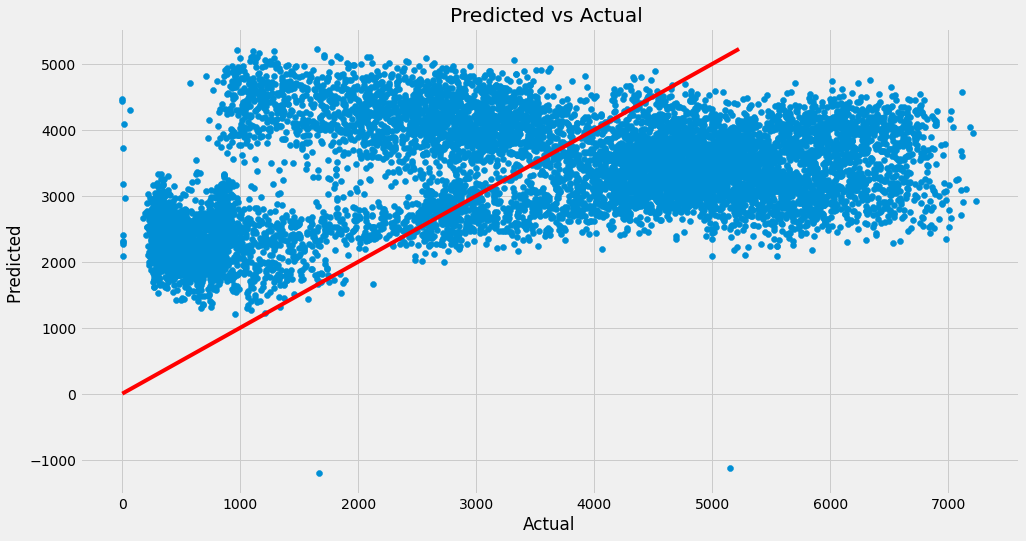

In [80]:



##Y.drop(['date_time'], axis=1)


xtrain,xtest,ytrain,ytest=train_test_split(X,Y,test_size=0.25,random_state=0)

LR = LinearRegression()

LR.fit(xtrain,ytrain)

pred = LR.predict(xtest)

import sklearn.metrics as metrics
print('R Squared : ',metrics.r2_score(ytest,pred))
print('Mean Absolute Error : ',metrics.mean_absolute_error(ytest,pred))
print('Mean Squared Error : ',metrics.mean_squared_error(ytest,pred))
print('Root Mean Squared Error : ',np.sqrt(metrics.mean_squared_error(ytest,pred)))



for i in range(len(data.columns)-1):
    X=  data[[data.columns[i]]]
    Y=  data[['traffic_volume']]
    xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.25,random_state = 0)
    LR.fit(xtrain,ytrain)
    pred = LR.predict(xtest)
    print(data.columns[i],': ',round(metrics.r2_score(ytest,pred),4))

for i in range(len(data.columns)-1):
    X=  data[['temp','hour',data.columns[i]]]
    Y=  data[['traffic_volume']]
    xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.25,random_state = 0)
    LR.fit(xtrain,ytrain)
    pred = LR.predict(xtest)
    print(data.columns[i],round(metrics.r2_score(ytest,pred),4))

for i in range(len(data.columns)-1):
    X=  data[['temp','hour','weather_description',data.columns[i]]]
    Y=  data[['traffic_volume']]
    xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.25,random_state = 0)
    LR.fit(xtrain,ytrain)
    pred = LR.predict(xtest)
    print(data.columns[i],round(metrics.r2_score(ytest,pred),4))

for i in range(len(data.columns)-1):
    X=  data[['temp','hour','weather_description','holiday',data.columns[i]]]
    Y=  data[['traffic_volume']]
    xtrain,xtest,ytrain,ytest = train_test_split(X,Y,test_size = 0.25,random_state = 0)
    LR.fit(xtrain,ytrain)
    pred = LR.predict(xtest)
    print(data.columns[i],round(metrics.r2_score(ytest,pred),4))

plt.figure(figsize=(15,8))
plt.scatter (ytest, pred) 
range = [ytest.min (), pred.max ()] 
plt.plot (range, range, 'red') 
plt.title('Predicted vs Actual ')
plt.xlabel ('Actual') 
plt.ylabel ('Predicted ') 
plt.show ()

In [78]:
xtrain.head()

,temp,hour,day_of_week
39187,289.470,8,4
3818,278.083,2,4
8049,274.950,11,0
18225,279.930,17,5
19866,276.490,18,1
